Fetch information about a specific person identified by his/her ORCID ID, and handle API errors.

[Download Notebook](https://github.com/researchgraph/augment-api-beta/blob/main/docs/notebooks/publications.ipynb)

In [9]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ast
import altair as alt
import networkx as nx
import nx_altair as nxa
from wordcloud import WordCloud, STOPWORDS 
import pandas as pd
from datetime import datetime, date
import requests
import json

import os
from os.path import join, dirname
from dotenv import load_dotenv
load_dotenv();

### ORCID ID not found

In [10]:
# ORCID ID not found
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0003-XXXX-XXXX"

url = f'https://api.researchgraph.ai/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 400:
    print(r.json()["message"])

Augment API query complete  400
FAILED: Invalid ORCID 0000-0003-XXXX-XXXX


### Missing API_KEY

In [11]:
# Missing API_KEY
API_KEY = ''
ORCID = "0000-0002-0715-6126"

url = f'https://api.researchgraph.ai/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 401:
    print(f'Authentication error.')

Augment API query complete  401
Authentication error.


### ORCID ID does exist

In [12]:
# ORCID ID does exist
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0002-0068-716X"

url = f'https://api.researchgraph.ai/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 200 and r.json()[0]["nodes"]["researchers"]:    
    researchers = r.json()[0]["nodes"]["researchers"]
    
    researcher = None
    for i in range(len(researchers)):
        if researchers[i]["orcid"] == ORCID:
            researcher = researchers[i]

print()
print(f'ORCID: {researcher["orcid"]}')
print(f'First name: {researcher["first_name"]}')
print(f'Last name: {researcher["last_name"]}')
print()
print(f'The researcher {researcher["full_name"]} is connected to {r.json()[0]["stats"]}.')

Augment API query complete  200

ORCID: 0000-0002-0068-716X
First name: Cameron
Last name: Neylon

The researcher Cameron Neylon is connected to {'datasets': 18, 'grants': 0, 'organisations': 208, 'publications': 139, 'researchers': 126}.


### List of publications as bibtex
Only includes publications with DOIs, and duplicate versions removed, sorted by publication year in descending order

In [13]:
# include all publications
pd.set_option("display.max_rows", None)

df = pd.DataFrame(r.json()[0]["nodes"]["publications"], columns=['doi', 'publication_year', 'title'])
df = df.dropna()
df = df.drop_duplicates(subset=['publication_year', 'title'])
df = df.sort_values(by=['publication_year','doi'], ascending=False)

In [14]:
data = []
for index, row in df.iterrows():
    url = f'https://data.crosscite.org/application/x-bibtex/{row["doi"]}'
    ra = requests.get(url)
    print(f'Crosscite API query for {row["doi"]} complete', ra.status_code)
    data.append(ra.text)

bib = '\n'.join(data)
with open(researcher['last_name'].lower() + '_publications.bib', 'a') as fp:
    fp.write(bib)

Crosscite API query for 10.7717/peerj.11391 complete 200
Crosscite API query for 10.5281/zenodo.4893802 complete 200
Crosscite API query for 10.5281/zenodo.4680985 complete 200
Crosscite API query for 10.5281/zenodo.4663353 complete 200
Crosscite API query for 10.1007/978-3-030-71305-8_36 complete 200
Crosscite API query for 10.7554/elife.57067 complete 200
Crosscite API query for 10.6084/m9.figshare.13010000.v1 complete 200
Crosscite API query for 10.6084/m9.figshare.13010000 complete 200
Crosscite API query for 10.5281/zenodo.4040402 complete 200
Crosscite API query for 10.5281/zenodo.3620964 complete 200
Crosscite API query for 10.4000/proceedings.elpub.2020.20 complete 200
Crosscite API query for 10.4000/proceedings.elpub.2020.18 complete 200
Crosscite API query for 10.1201/9780429324383-2 complete 200
Crosscite API query for 10.1186/s41073-020-00099-8 complete 200
Crosscite API query for 10.1162/qss_a_00052 complete 200
Crosscite API query for 10.1162/qss_a_00031 complete 200
Cros

### Publications by year

Also handling years without any publications. Using the ResearchGraph color for publications.

In [15]:
plot_title = alt.TitleParams(f'{researcher["full_name"]} (ORCID {ORCID})', subtitle=['Publications by Year'])
alt.Chart(df, title=plot_title).mark_bar(color='#49B1F4').properties(width=500).encode(
    x=alt.X("publication_year:O", axis=alt.Axis(title='Publication Year', labelAngle=0, labelSeparation=10)),
    y=alt.Y("count:Q", impute=alt.ImputeParams(value=0, keyvals={"start": int(min(df['publication_year'].tolist())), "stop": datetime.now().year }), axis=alt.Axis(title=None))
).transform_aggregate(
    count='count(publication_year)',
    groupby=["publication_year"]
).configure_title(
    fontSize=18
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

alt.Chart(...)

### Topics of publications

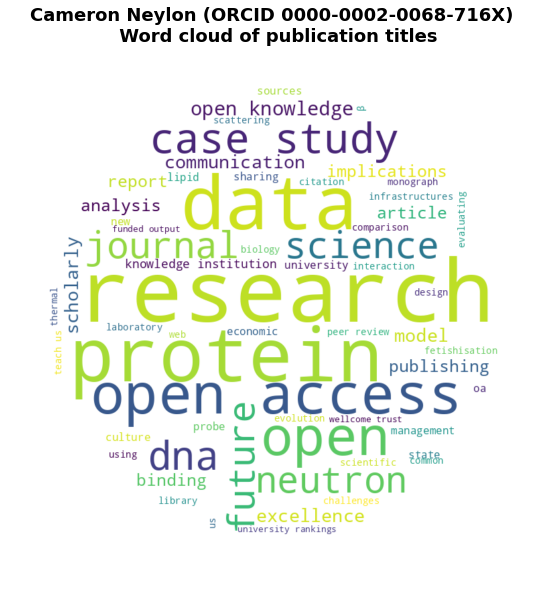

In [16]:
stopWords = set(STOPWORDS)
stopWords.add('_')

titleWords=[]
for index, row in df.iterrows():
    tokens = [t.lower() for t in row['title'].split()]     
    titleWords += tokens
     
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 345 ** 2
mask = 255 * mask.astype(int)
    
wordcloud = WordCloud(width = 600, height = 600,
            max_words = 100,
            background_color ='white', 
            stopwords = stopWords, 
            min_font_size = 12, 
            mask = mask).generate(" ".join(titleWords))
    
fig, ax = plt.subplots(1, 1, figsize = (8, 8), facecolor = None)
ax.set_title(f'{researcher["full_name"]} (ORCID {researcher["orcid"]}) \n Word cloud of publication titles', fontsize=18, fontweight="semibold")
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()